In [2]:
import os
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()


In [3]:
batch_size = 15
models_path = "E:/Smoke/Models/"
model_name = ""
model_path = models_path + model_name
print(model_path)
n_epochs = 300
learning_rate = 0.0005
num_workers = 0


transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

E:/Smoke/Models/


In [4]:
train_set = 'E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train'
valid_set = 'E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Validation'

train_data = datasets.ImageFolder(train_set, transform=transform)
valid_data = datasets.ImageFolder(valid_set, transform=transform)

a = train_data.class_to_idx
print(a)
# print(a["Train"])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': valid_loader
}

{'Fire': 0, 'Neutral': 1, 'Smoke': 2}


In [5]:
train_loader

In [6]:
train_data

Dataset ImageFolder
    Number of datapoints: 420
    Root location: E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
valid_data


Dataset ImageFolder
    Number of datapoints: 105
    Root location: E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
class_names = ['Fire', 'Neutral', 'Smoke']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Fire', 'Neutral', 'Smoke']


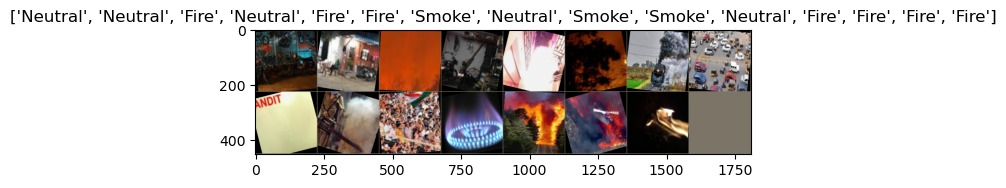

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = loaders["train"].dataset.classes
print(class_names)

# Get a batch of training data
inputs, classes = next(iter(train_loader))
# print(inputs, classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
model = models.resnet50(pretrained=True)



use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()

# model

c:\Users\XYMA_HPC\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\XYMA_HPC\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048,128),
                                      torch.nn.ReLU(),
                                       torch.nn.Linear(128,3),
                                       torch.nn.Softmax()
                                      )

for param in model.fc.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model.cuda()
else:
    print("entered else")
    model_transfer = model

# model

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.fc.parameters(), lr=learning_rate)

In [13]:
#Training

train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []

def train(n_epochs, loader, model, optimizer, criterion, save_path):
    
    valid_loss_min = np.Inf
       
    for epoch in range(1, (n_epochs+1)):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loader['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)

            #The code _, preds = torch.max(output, 1) returns the index of the maximum value in the output tensor 
            # along the first dimension. The first underscore is a placeholder for the maximum value itself, which 
            # is not needed in this case. The second underscore, preds, is a tensor containing the indices of the maximum values.
            # This code is often used in PyTorch for image classification tasks. For example, if the output tensor contains the probabilities 
            # of each class for an image, then the code above will return the index of the class with the highest probability. This index can then be used to get the predicted class label.
        
            _, preds = torch.max(output, 1)  #The dim=1 argument in the code _, preds = torch.max(output, 1) specifies that the function should find the maximum value in each 
                                             #row of the output tensor. This is because the first dimension of a tensor is typically the number of rows.
          

            # print(torch.max(output, 1), "torch.max(output, 1)")
            # print("printing preds", preds)


          
            #torch.return_types.max(
            # values=tensor([0.3657, 0.3671, 0.3538, 0.3936, 0.3950, 0.3564, 0.4164, 0.3460, 0.3447,
            #         0.4042, 0.3674, 0.3802, 0.4094, 0.3741, 0.3752], device='cuda:0',
            #     grad_fn=<MaxBackward0>),
            # indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], device='cuda:0')) torch.max(output, 1)
            # printing preds tensor([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], device='cuda:0')
          
  
  
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_acc = train_acc + torch.sum(preds == target.data)

            #https://datascience.stackexchange.com/questions/60613/explanation-behind-the-calculation-of-training-loss-in-deep-learning-model
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            model.eval()
     
     
     
        for batch_idx, (data, target) in enumerate(loader['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            _, preds = torch.max(output, 1)
            # print("printing preds", preds)
            loss = criterion(output, target)
            print(loss, "printitng loss")
            
            valid_acc = valid_acc + torch.sum(preds == target.data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        train_loss = train_loss/len(loader['train'].dataset)
        valid_loss = valid_loss/len(loader['valid'].dataset)
        train_acc = train_acc/len(loader['train'].dataset)
        valid_acc = valid_acc/len(loader['valid'].dataset)
        
        train_accuracy_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
        
        print('Epoch: {} \tTraining Acc: {:6f} \tTraining Loss: {:6f} \tValidation Acc: {:6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_acc,
            train_loss,
            valid_acc,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            print("Saved model at: ", model_path)
            trained_model = torch.save(model, save_path)
            valid_loss_min = valid_loss  
            
    return trained_model

In [14]:
#uncomment to train the model here
# trained_model = train(n_epochs, loaders, model, optimizer, criterion, save_path=model_path)


In [15]:
#Uncomment if you trained the model to view the plots. Else, the lists will be empty

plt.style.use("ggplot")
plt.figure()
loss_lis = [tensor.item() for tensor in train_loss_list]

print(loss_lis)

""" The training loss should decrease over time as the model learns from the data. 
However, a very low training loss doesn't necessarily mean the model 
will perform well on new, unseen data, as it may have overfit the training data"""

print("Last loss: ", train_loss_list[-1])
plt.plot(loss_lis, label="train_loss")
plt.title("Train-Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

[]


IndexError: list index out of range

<Figure size 640x480 with 0 Axes>


Train accuracy mean:  tensor(nan)
Valid accuracy mean:  tensor(nan)


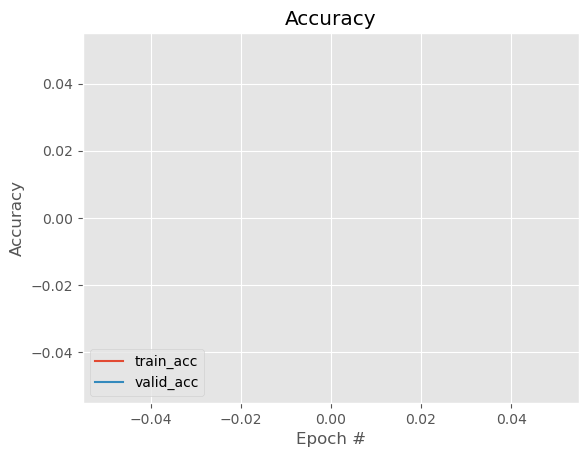

In [ ]:
#Uncomment if you trained the model to view the plots. Else, the lists will be empty

plt.style.use("ggplot")
plt.figure()

print()
train_acc_lis = [tensor.item() for tensor in train_accuracy_list]
valid_acc_lis = [tensor.item() for tensor in valid_accuracy_list]

mean_accuracy_train = torch.tensor(train_accuracy_list)
mean_accuracy_train = mean_accuracy_train.mean()
print("Train accuracy mean: ", mean_accuracy_train)
mean_accuracy_valid = torch.tensor(valid_accuracy_list)
mean_accuracy_valid = mean_accuracy_valid.mean()
print("Valid accuracy mean: ", mean_accuracy_valid)

plt.plot(train_acc_lis, label="train_acc")
plt.plot(valid_acc_lis, label="valid_acc")

plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [16]:
from PIL import Image

class_names = ['Fire', 'Neutral', 'Smoke']

def predict(image, model_path):

    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    image = image.cuda()
    # print(image)

    if model_path == "E:\Smoke\Final\laptestingmodel_200epochs.pt":
        # print("Entered laptesting model trained for 200 epochs")
        model = torch.load(model_path)
    else:
        print("Entered else")
        model.load_state_dict(torch.load(model_path), strict = False)
        model.eval()
        model.to(device=device)


    with torch.no_grad():
        pred = model(image)
        
    # print(pred, "pred")
    idx = torch.argmax(pred)
    # print("idx", idx)
    prob = pred[0][idx].item()*100

    # print(class_names[idx], "class_names[idx]")
    
    return class_names[idx], prob

E:\Smoke\Final\laptestingmodel_200epochs.pt model_path
RESULTS FROM MODEL-  E:\Smoke\Final\laptestingmodel_200epochs.pt
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360 at 0x1B344972F40>


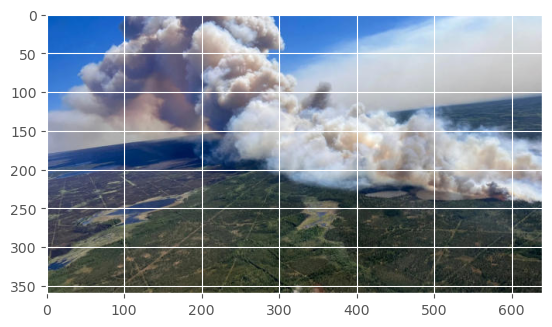

Smoke 100.0
RESULTS FROM MODEL-  E:\Smoke\Final\laptestingmodel_200epochs.pt
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x565 at 0x1B34473D580>


c:\Users\XYMA_HPC\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


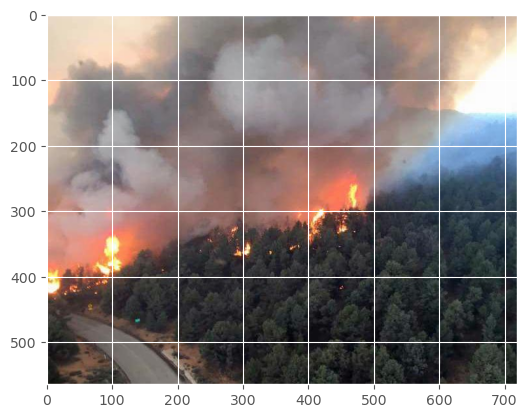

Fire 100.0
RESULTS FROM MODEL-  E:\Smoke\Final\laptestingmodel_200epochs.pt
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x1B344825730>


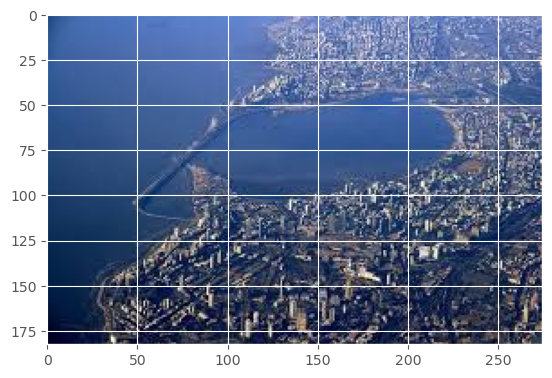

Fire 96.82435989379883
RESULTS FROM MODEL-  E:\Smoke\Final\laptestingmodel_200epochs.pt
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x194 at 0x1B345790FD0>


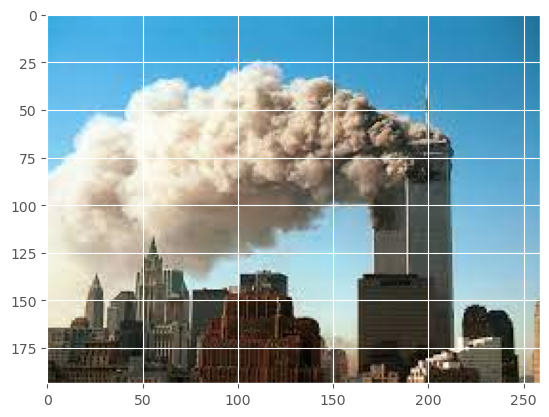

Smoke 100.0


In [17]:
def test(testing_image_path, model_path):
    print("RESULTS FROM MODEL- ", str(model_path))

    img = Image.open(testing_image_path)
    print(img)
    plt.imshow(img)
    plt.show()


    prediction, prob = predict(image=img, model_path=model_path)
    print(prediction, prob)
    

# for idx, img_file in enumerate(os.listdir('E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train/Neutral')):
 
#     if idx > 5:
#         print(img_file, "IMG FILE")
#         img_path = os.path.join('E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train/Neutral', img_file)
#         test(img_path)

model_path = "E:\Smoke\Final\laptestingmodel_200epochs.pt"
print(model_path, "model_path")

test(testing_image_path = "E:/Smoke/smoke1.jpg", model_path=model_path)
test(testing_image_path = "E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Others/fire/Chimney-Fire3.jpg", model_path=model_path)
test(testing_image_path = "C:/Users/XYMA_HPC/Downloads/images - 2024-01-10T145341.358.jpg", model_path=model_path)
test(testing_image_path = "E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Others/download (15).jpg", model_path=model_path)

In [24]:
import cv2

def show_available_cameras():
    for i in range(1):  # Checking up to index 9 (adjust this number as needed)
        print("entered for")
        cap = cv2.VideoCapture(i)
        if not cap.isOpened():
            print("Camera is not available")
        if cap.isOpened():
            print(f"Camera index {i} is available.")
            cap.release()
            return i



def live_stream_predict(model_path, webcam_index):

    print("RESULTS FROM MODEL: ", str(model_path))
    # Load your pretrained model
    # loaded_model = torch.load(model_path)
    # loaded_model.eval()  # Set the model to evaluation mode
    
    webcam_index = webcam_index
    # cap = cv2.VideoCapture(webcam_index) #VideoCapture(The webcam index refers to the identification number assigned to your webcam by the system. )
    cap = cv2.VideoCapture("C:/Users/XYMA_HPC/Downloads/The West Fertilizer Company plant explosion, 10 years later _ KVUE.mp4")


    while True:
        ret, frame = cap.read()  # Read a frame from the webcam
        cv2.imshow('frame', frame)  # Display the frame
        
        # Convert the OpenCV frame to PIL image format
        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        prediction, prob = predict(pil_img, model_path=model_path)  # Use the loaded model for predictions
        
        # Show the prediction on the frame
        cv2.putText(frame, f"{prediction} ({prob:.2f}%)", (5,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow('frame', frame)  # Display the frame with prediction
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [25]:
webcam_index = show_available_cameras()
live_stream_predict(model_path = model_path, webcam_index=webcam_index)

entered for
Camera index 0 is available.
RESULTS FROM MODEL:  E:\Smoke\Final\laptestingmodel_200epochs.pt
